### Da Si - 445057
###### University of Chicago - FInancial Mathematics
###### FINM 33150 - Regression Analysis and Quantitative Trading Strategies
###### Homework3: Benchmarking Simple Spread Trading

Below is my code and analysis for this homework assignment. I have designed it so that the whole trading strategy is in a function called 'spreadTrading'. This is because of the analysis part; to do analysis, I vary the parameters by looping through the spreadTrading function. I have used data from the EOD Quandl.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg
from datetime import timedelta
import statsmodels.api as sm

# change font size of the x, y axis
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

In [33]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities, start, end):
    qdata = Quandl.get(list(my_securities), returns="pandas", trim_start=start, trim_end=end, authtoken="v21snmSix9KyXBWc1RkF")
    return qdata

In [4]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('.')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

## Note : 
In this function I set **g** and **j** to be some number that is **G** and **J** standard deviation from mean of spread across the whole time period. Although it seems to have lookahead bias, it is really not a big issue in our case since this is basically same as setting g and j to be any two values and test them on different levels (since we can change G and J to any value). The real intuition of setting g and j this way is that in real treading and backtesting we can change the calculation of g and j based on the distribution of the past n days of the spread. And because the time range in this dataset is small so I decided not to set window for calculation of past mean and standard deviation of spread.

In [22]:
def spreadTrading(X,Y,start,end,M,J,G,s):
    """
    X,Y ~ ETF tickers
    start,end ~ start date and end date of data 
    M ~ timeframe for return calculation
    N ~ number of standard deviation that g and j are around the mean of spread
    s ~ stop loss threshold
    data ~ DataFrame containing the daily close price for ETF X and Y, and the volumne for X
    
    The function returns 6 pandas Series: 4 are signals of buy/sell/stop loss/end of month, 
    they are used later for plotting purposes. The rest two are Series of daily cash and position value.
    In this way we can get the total portfolio level and calculate profit.
    """
    # fetch data
    raw_data = fetch_quandl(("EOD/" + X , "EOD/" + Y), start, end)
    renamed_data = clean_quandl_columns(raw_data)
    data = renamed_data[[X + ":Adj_Close", X + ":Adj_Volume", Y +":Adj_Close"]]
    data.columns = ["X:Adj_Close", "X:Adj_Volume", "Y:Adj_Close"]
    renamed_data = None # delete old dataset to save space
    # rolling 15 day dollar volume
    Nt = data["X:Adj_Close"]* data["X:Adj_Volume"].rolling(window = 15).median()
    #inial capital
    K = Nt.max()*2 
    #trade size
    data["size"] = Nt / 100 
    # calculate log return and spread
    data["X_ret"] = np.log(data["X:Adj_Close"]) - np.log(data["X:Adj_Close"].shift(M))
    data["Y_ret"] = np.log(data["Y:Adj_Close"]) - np.log(data["Y:Adj_Close"].shift(M))
    data["spread"] = data["X_ret"] - data["Y_ret"]

    mean = data.spread.mean()
    std = data.spread.std()
    g = mean + G * std
    j = mean + J * std
    # get the first date of the following month
    d = data.index[M]
    startDate = pd.date_range(start = d, periods = 1, freq = 'BMS') # get first business day of portfolio
    endOfMonths =  pd.date_range(start, end, freq = 'BM') # end of months (business day, maybe holiday)
    diff = pd.Series(data.index.month).diff()
    mask = (diff != 0)
    startOfMonth = data.index[mask]
    startDate = startOfMonth[startOfMonth.month == startDate[0].month][0] # make sure startDate is not a holiday
    endOfMonth = data.index[mask.shift(-1).fillna(False)] # this way excludes any possible holidays
    temp = endOfMonth.tolist()
    temp.append(endOfMonths[-1])
    endOfMonth = pd.DatetimeIndex(temp)
    # time range for actual trading (1 day ahead for recording purposes)
    timeFrame = data.index[data.index >= (startDate- timedelta(days = 1))] 
    temp = timeFrame.tolist()
    temp = [startDate- timedelta(days = 1)] + temp
    timeFrame = pd.DatetimeIndex(temp)
    temp = None
    # set variables for trading simulation
    hold = 0
    X_position = 0
    Y_position = 0
    tradedCash = 0
    positionVal = pd.Series(np.zeros(len(timeFrame)), index = timeFrame) # position value
    Cash = pd.Series(np.zeros(len(timeFrame)), index = timeFrame) # cash of portfolio
    # set initial cash
    Cash[0] = K
    # record buy/sell/end of month signals for plotting
    SignalL = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    SignalS = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    SignalSL = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    SignalEOM = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    """
    begin trading simulation, the order of if is to check sell signal first, then buy signal and stop loss signal
    in the end. This order allows same-day re-entry after selling and prevent re-entry when stop loss is triggered
    """
    for day in timeFrame[1:]:
        yesterday = timeFrame[timeFrame.get_loc(day)-1]
        # cumulate cash from yesterday
        Cash[day] = Cash[yesterday] 
        spread = data.loc[day,"spread"] # spread of the day
        # value of current position (if there is one)
        positionVal[day] = data.loc[day,"X:Adj_Close"] * X_position + data.loc[day,"Y:Adj_Close"] * Y_position

        # check whether to sell
        if (hold == 1 and spread < j) or (hold == -1 and spread > -j) or (hold != 0 and (day in endOfMonth)):   
            # record signal
            # notice if entering from positive g then exit when cross j from above, 
            # if entering from negative g then exit when cross -j from below
            SignalS[day] = (hold == 1 and spread < j) or (hold == -1 and spread > -j)
            SignalEOM[day] = (day in endOfMonth)
            # adjust cash value after flatting position
            Cash[day] = Cash[day] + positionVal[day]
            # reset position to zero
            X_position = 0
            Y_position = 0
            positionVal[day] = 0
            tradedCash = 0
            hold = 0
            
        # check whether to buy
        if (hold == 0) and (abs(spread) > g) and (day not in endOfMonth):
            # record signal
            SignalL[day] =(abs(spread) > g)
            # amount of position for X and Y
            X_position = - np.sign(spread) * int (data.loc[day,"size"] / data.loc[day,"X:Adj_Close"])
            Y_position = + np.sign(spread) * int (data.loc[day,"size"] / data.loc[day,"Y:Adj_Close"])
            # gross traded cash
            tradedCash = data.loc[day,"X:Adj_Close"] * abs(X_position) + data.loc[day,"Y:Adj_Close"] * abs(Y_position)
            # real value of combined long/short position
            positionVal[day] = data.loc[day,"X:Adj_Close"] * X_position + data.loc[day,"Y:Adj_Close"] * Y_position
            # cash adjustment after creating portfolio
            Cash[day] = Cash[day] - positionVal[day]
            hold = np.sign(spread)
        
        # check stop loss
        if (hold !=0) and (positionVal[day] / tradedCash < -s):
            SignalSL[day] = (positionVal[day] / tradedCash < -s)
            Cash[day] = Cash[day] + positionVal[day]
            # reset position to zero
            X_position = 0
            Y_position = 0
            positionVal[day] = 0
            tradedCash = 0
            hold = 0
    d = {'spread':data.spread[timeFrame],
         'SignalL':SignalL,
         'SignalS':SignalS,
         'SignalSL':SignalSL,
         'SignalEOM':SignalEOM,
         'MTM':Cash + positionVal,
         'Profit': Cash + positionVal - K
         }
    result = pd.DataFrame(d),g,j
    return result

In [24]:
def plotResult(data):
    # plot the signals along the spread and along the cumulative profit
    mean = data.spread.mean()
    std = data.spread.std()
    g = mean + G * std
    j = mean + J * std
    fig = plt.figure(figsize=(20,12))
    plt.plot(data["spread"], label = 'Spread')
    plt.hold(True)
    # plot signal
    plt.scatter(y = data.loc[data.index[data.SignalL],'spread'], x = data.index[data.SignalL], label = 'Entry', c = 'g', s = 50)
    plt.scatter(y = data.loc[data.index[data.SignalS],'spread'], x = data.index[data.SignalS], label = 'Exit', c = 'r', s = 50)
    plt.scatter(y = data.loc[data.index[data.SignalSL],'spread'], x = data.index[data.SignalSL], label = 'Stop Loss', c = 'k', s = 50)
    plt.scatter(y = data.loc[data.index[data.SignalEOM],'spread'], x = data.index[data.SignalEOM], label = 'EOM', c = 'c', s = 50)
    # plot bound
    plt.plot((data.index[0], data.index[-1]), (g, g),'m-',label = 'g')
    plt.plot((data.index[0], data.index[-1]), (j, j),'b-',label = 'j')
    plt.plot((data.index[0], data.index[-1]), (-g, -g),'m-')
    plt.plot((data.index[0], data.index[-1]), (-j, -j),'b-')
    plt.legend(loc = 2, prop={'size':15},numpoints = 1)
    # change axis range
    axes = plt.gca()
    axes.set_xlim([data.index[0], data.index[-1]])

    fig2 = plt.figure(figsize=(20,12))
    Profit = data.Profit
    plt.plot(Profit, label = 'Profit')
    plt.hold(True)
    plt.scatter(y = Profit.loc[data.index[data.SignalL]], x = data.index[data.SignalL], label = 'Entry', c = 'g', s = 50)
    plt.scatter(y = Profit.loc[data.index[data.SignalS]], x = data.index[data.SignalS], label = 'Exit', c = 'r', s = 50)
    plt.scatter(y = Profit.loc[data.index[data.SignalSL]], x = data.index[data.SignalSL], label = 'Stop Loss', c = 'k', s = 50)
    plt.scatter(y = Profit.loc[data.index[data.SignalEOM]], x = data.index[data.SignalEOM], label = 'EOM', c = 'c', s = 50)
    plt.legend(loc = 2, prop={'size':20},numpoints = 1)
    axes = plt.gca()
    axes.set_xlim([data.index[0], data.index[-1]])

** The double_test() function is used to determine a good pair of g and j for each ETF. **

In [29]:
# This is a double loop that test J and width (G - J) at same time for specific M, it returns a table of profits
def double_test(X,Y,M):
    s = float('inf')
    J_range = np.arange(0.0,1.6,0.1)
    w_range = np.arange(0.0,1.1,0.1)
    test = pd.DataFrame(index = J_range, columns = w_range, dtype = float)
    for J in J_range:
        for w in w_range:
            result,g,j = spreadTrading(X,Y,start,end,M,J,J+w,s)
            Profit = result.Profit
            test.loc[J,w] = Profit[-1]
    return test

In [8]:
# Calculate the Sharpe and Sortino ratio for a series of returns.

def ratios(r):
    '''
    Since the risk free rate during the whole period stays zero, 
    I simply compute the mean and the standard deviation of the returns
    '''
    r = r[~np.isnan(r)]
    r = r[r != float('Inf')]
    r = r[r != -float('Inf')]
    rNeg = r[r < 0]
    sharpe = np.sqrt(252) * r.mean() / r.std()
    sortino = np.sqrt(252) * r.mean() / rNeg.std()
    return sharpe, sortino

** Below is a sample plot using the plotResult() function that I defined. I used this plot together with the double_test() function to determine reasonable g and j for each pair of ETF. I choose g and j such that they bring a good return and the trades that are showed on plot do not look too few or too frequent. **

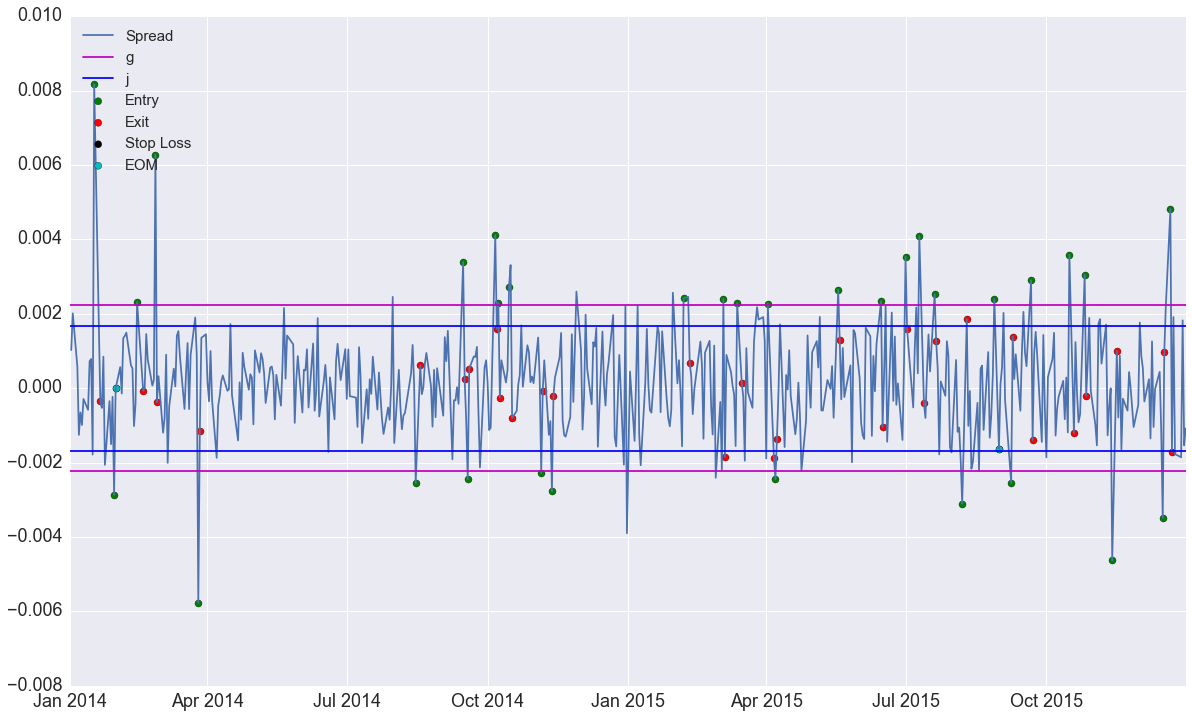

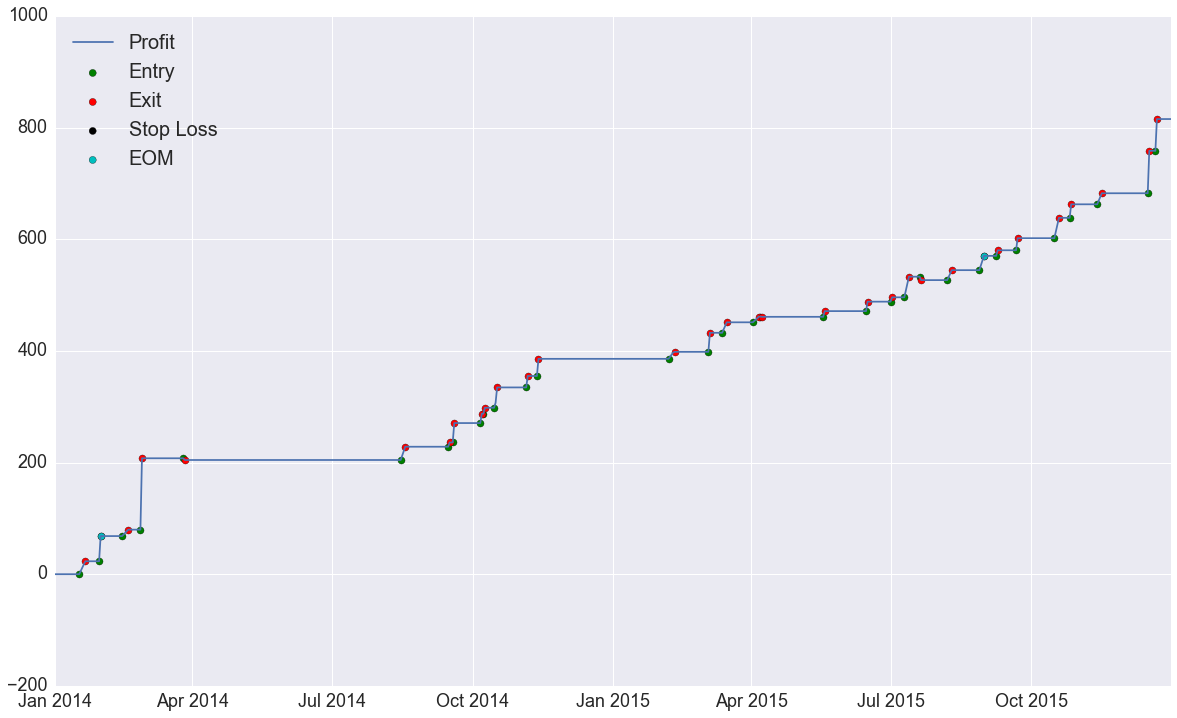

In [25]:
# set ETF tickers, start end date and parameters
################################################
X = 'SIVR'
Y = 'SLV'
start = "2013-12-02"
end = "2015-12-31"
M = 20
J = 1.1
G = 1.5
s = float('inf')
result,g,j = spreadTrading(X,Y,start,end,M,J,G,s)
plotResult(result)

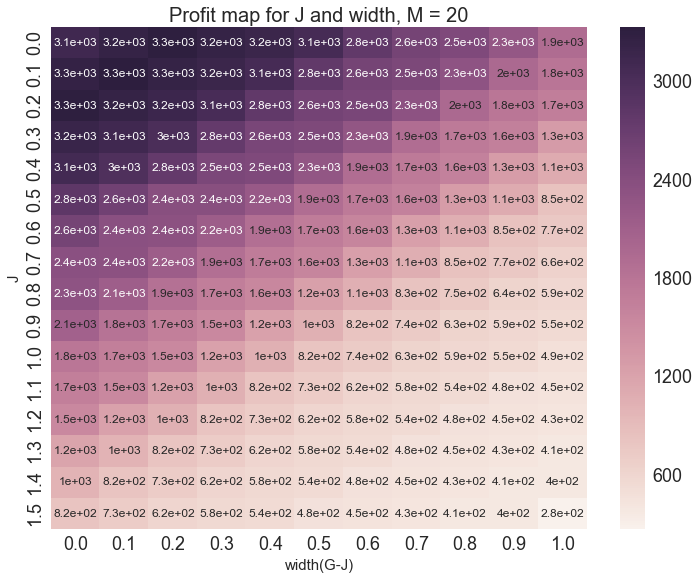

In [30]:
# The vertical axis is J, horizontal axis is width = G - J
test = double_test(X,Y,20)
plt.figure(figsize=(12, 9))
ax = sns.heatmap(test, annot = True)
sns.axlabel('width(G-J)','J',fontsize = 15)
sns.plt.title('Profit map for J and width, M = '+ str(M), fontsize = 20)

** The same analysis is conducted for all 10 pairs of ETFs to determine good g and j. Then I put all the good parameteres into list **

In [31]:
# Define lists of all the ETF tickers and parameters to be used in loop  
Xlist = ['RYU','IST','RING','XSD','PBE','IEO','PXJ','RTH','SIVR','HYLD']
Ylist = ['XLU','IYZ','GDX','SMH','XBI','XOP','OIH','XRT','SLV','JNK']
Jlist = [1.3,0.6,0.8,1.5,1.1,0.8,0.7,1.5,1.1,1.5]
Glist = [1.6,0.7,1.1,1.7,2.0,1.3,0.9,2.3,1.5,2.5]

** Now it is time to calculate the Sharpe and Sortino ratios for each portfolio **

In [34]:
# Create a DataFrame to store all the values
R = pd.DataFrame(index = range(10), columns = ['X','Y','g','j','Sharpe','Sortino'])
# Dictionary to store all return series to be used in regressions
returns = {}
start = "2013-12-02"
end = "2015-12-31"
s = float('inf')
M = 20
i = 0
for i in range(10):
    result,g,j = spreadTrading(Xlist[i],Ylist[i],start,end,M,Jlist[i],Glist[i],s)
    MTM = result.MTM
    r = MTM.pct_change()
    sharpe, sortino = ratios(r)
    R.loc[i,'X'] = Xlist[i]
    R.loc[i,'Y'] = Ylist[i]
    R.loc[i,'g'] = round(g,4)
    R.loc[i,'j'] = round(j,4)
    R.loc[i,'Sharpe'] = round(sharpe,4)
    R.loc[i,'Sortino'] = round(sortino,4)
    returns[i] = r
R

,X,Y,g,j,Sharpe,Sortino
0,RYU,XLU,0.016,0.013,1.3361,1.1215
1,IST,IYZ,0.0201,0.017,1.4526,1.5376
2,RING,GDX,0.0093,0.0059,2.0937,2.4292
3,XSD,SMH,0.0511,0.0456,1.066,0.4615
4,PBE,XBI,0.0637,0.0318,0.9338,0.4523
5,IEO,XOP,0.0565,0.0405,0.6516,0.479
6,PXJ,OIH,0.0036,0.0009,0.5191,0.7304
7,RTH,XRT,0.0586,0.0417,1.2123,1.3557
8,SIVR,SLV,0.0022,0.0017,2.9295,8.9143
9,HYLD,JNK,0.0407,0.021,-0.5626,-0.2805


** Above are the Sharpe and Sortino ratios for all ETF pairs together with the g and j level. Since I already tested that the risk free rate for the whole period is zero, it is okay to calculate those ratios before importing the Fama-French factors. Then I imported the factors and combine the returns with the previous 10 return series. **

In [35]:
# Convert return series into DataFrame and combine it with Fama-French factors
returns = pd.DataFrame(returns)
factor = Quandl.get('KFRENCH/FACTORS_D', returns="pandas", trim_start=returns.index[0], trim_end=returns.index[-1], authtoken="z2yoF1Mryjst1k4hSN7p")
factor = factor/100
returns = pd.concat([returns,factor],axis = 1)
returns[returns == float('inf')] = np.nan
returns[returns == -float('inf')] = np.nan

In [36]:
returns.head()

,0,1,2,3,4,5,6,7,8,9,Mkt-RF,SMB,HML,RF
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0088,-0.0024,0.0011,0.0
2014-01-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003,0.0037,0.0003,0.0
2014-01-06,0.0,0.0,-0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0034,-0.0056,0.0026,0.0
2014-01-07,0.0,0.0,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0068,0.0037,-0.0039,0.0


In [37]:
# Run double loop to get the hedged ratios for returns from each pair
R2 = R[['Sharpe','Sortino']]
for i in range(10):
    for j in ['Mkt-RF','SMB','HML','RF']:
        model = sm.OLS(returns[i],returns[j],missing = 'drop')
        result = model.fit()
        sharpe, sortino = ratios(result.resid)
        R2.loc[i,'Sharpe' + '('+j+')'] = round(sharpe,4)
        R2.loc[i,'Sortino'+ '('+j+')'] = round(sortino,4)
R2

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Sharpe,Sortino,Sharpe(Mkt-RF),Sortino(Mkt-RF),Sharpe(SMB),Sortino(SMB),Sharpe(HML),Sortino(HML),Sharpe(RF),Sortino(RF)
0,1.3361,1.1215,1.3608,2.4688,1.3412,2.4284,1.3754,2.4375,1.3361,1.1215
1,1.4526,1.5376,1.4636,1.7466,1.4786,1.8054,1.4511,1.8032,1.4526,1.5376
2,2.0937,2.4292,2.1441,3.0679,2.0317,3.0497,2.0490,3.0546,2.0937,2.4292
3,1.066,0.4615,1.0312,1.8980,1.2061,2.0335,0.9856,1.8606,1.0660,0.4615
4,0.9338,0.4523,0.9278,1.1053,0.9887,1.1215,0.8641,1.0573,0.9338,0.4523
5,0.6516,0.479,0.6093,0.8167,0.7639,0.9829,0.6450,0.8701,0.6516,0.4790
6,0.5191,0.7304,0.5144,0.7334,0.5333,0.7572,0.5617,0.8022,0.5191,0.7304
7,1.2123,1.3557,1.1932,2.3438,1.2695,2.3719,1.1393,2.3130,1.2123,1.3557
8,2.9295,8.9143,2.9213,59.8918,2.9146,57.0832,2.9010,59.1782,2.9295,8.9143
9,-0.5626,-0.2805,-0.5768,-0.6006,-0.5080,-0.5104,-0.5058,-0.4953,-0.5626,-0.2805


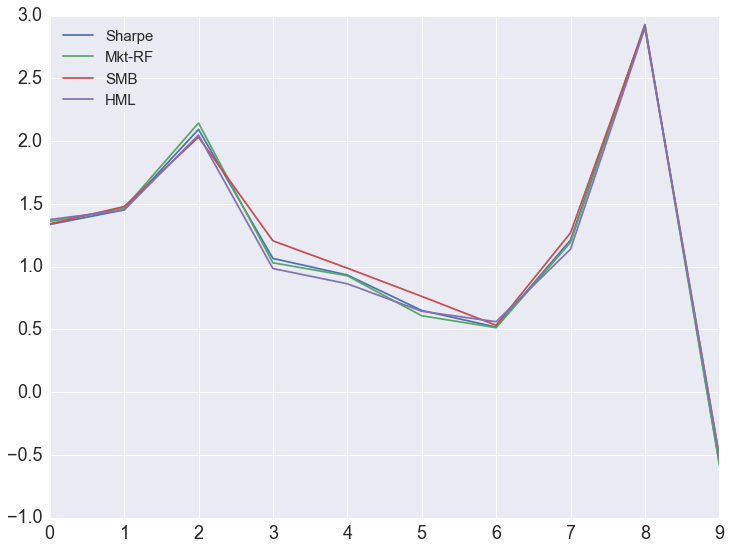

In [48]:
plt.figure(figsize=(12, 9))
plt.plot(R2.Sharpe)
plt.hold(True)
plt.plot(R2['Sharpe(Mkt-RF)'],label = 'Mkt-RF')
plt.plot(R2['Sharpe(SMB)'],label = 'SMB')
plt.plot(R2['Sharpe(HML)'],label = 'HML')
plt.legend(loc = 2,prop={'size':15})

** As we can expect, the regression on RF has R square of zero and thus does not change the Sharpe nor Sortino ratio. Also I checked the R square of the regressions and they are very small. This means that we are not hedging much and should not expect big differences in performance in terms of Sharpe and Soritno ratios. Also note that the Sortino ratio of pair 8 becomes extremely big after hedging, I plotted the daily return series and found that it is due to the fact that there are only 2 down days in the whole series. So the standard deviation of the hedged negative returns is very small. **

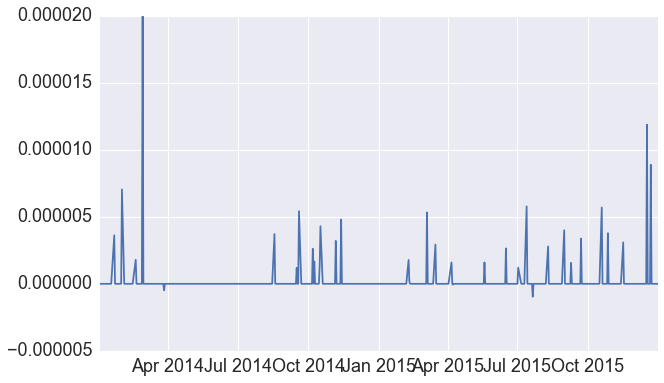

In [49]:
plt.figure(figsize=(10,6))
plt.plot(returns[8])
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [50]:
R3 = R[['Sharpe','Sortino']]
for i in range(10):
    model = sm.OLS(returns[i],returns[['Mkt-RF','SMB','HML','RF']],missing = 'drop')
    result = model.fit()
    sharpe, sortino = ratios(result.resid)
    R3.loc[i,'Sharpe(All Factors)'] = sharpe
    R3.loc[i,'Sortino(All Factors)'] = sortino
R3

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Sharpe,Sortino,Sharpe(All Factors),Sortino(All Factors)
0,1.3361,1.1215,1.414842,2.555618
1,1.4526,1.5376,1.502771,1.828738
2,2.0937,2.4292,1.968257,3.039167
3,1.066,0.4615,1.150591,2.002590
4,0.9338,0.4523,0.927026,1.090456
5,0.6516,0.479,0.794034,1.009417
6,0.5191,0.7304,0.594479,0.850212
7,1.2123,1.3557,1.192865,2.356734
8,2.9295,8.9143,2.861042,52.434850
9,-0.5626,-0.2805,-0.407592,-0.386287


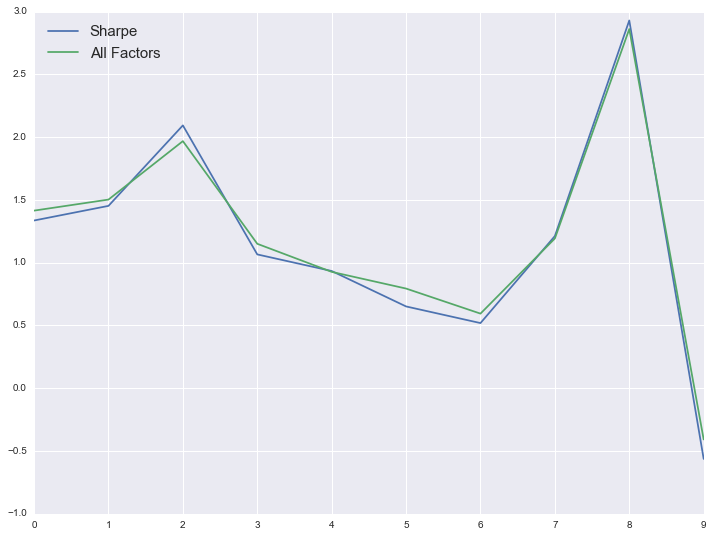

In [51]:
plt.figure(figsize=(12, 9))
plt.plot(R3.Sharpe)
plt.hold(True)
plt.plot(R3['Sharpe(All Factors)'],label = 'All Factors')
plt.legend(loc = 2,prop={'size':15})

** Above is the Sharpe and Sortino ratios for the portfolios hedged using all four factors. While ratios of some of the pairs are improved, some stay unchanged or even get lower. That simply means hedging using those factors have no significant impact on our portfolios. ** 